<a href="https://colab.research.google.com/github/wanasyraf4/CUDA-Regression/blob/main/cuBLAS_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Calling CUDA from Python to Speed Up Linear Algebra**

In [82]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1553  100  1553    0     0  12524      0 --:--:-- --:--:-- --:--:-- 12524
********************************************************************************
CUDA version could not be detected!
Try installing Chainer manually by: pip install chainer
********************************************************************************


In [106]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sympy 

import itertools
import functools

In [110]:
m = 2
X = 2
c = 2
y = m*X + c

A regressor is also known as: An independent variable

In [84]:
# Base class of regressor

class Regressor(object):

# estimate parameter given training dataset

# Parameters
# ----------
# X : (sample_size, n_features) cp.ndarray
#     training data input
# t : (sample_size,) cp.ndarray
#     training data target 

  def fit(self, X, t, **kwargs):
    self._check_input(X)
    self._check_target(t)
    if hasattr(self, "_fit"):
      self._fit(X, t, **kwargs)
    else:
      raise NotImplementedError

# Predict the output of the model

#  X : (sample_size, n_features) cp.ndarray
#             samples to predict their output
#         Returns
# -----------------------------------------------
#  y : (sample_size,) cp.ndarray
#      prediction of each sample

  def predict(self, X, **kwargs):
    self._check_input(X)
    if hasattr(self, "_predict"):
       return self._predict(X, **kwargs)
    else:
       raise NotImplementedError

  def _check_input(self, X):
      if not isinstance(X, cp.ndarray):
          raise ValueError("X(input) is not cp.ndarray")
      if X.ndim != 2:
          raise ValueError("X(input) is not two dimensional array")
      if hasattr(self, "n_features") and self.n_features != cp.size(X, 1):
          raise ValueError(
                "mismatch in dimension 1 of X(input) "
                "(size {} is different from {})"
                .format(cp.size(X, 1), self.n_features)
       )

  def _check_target(self, t):
    if not isinstance(t, cp.ndarray):
      raise ValueError("t(target) must be cp.ndarray")
    if t.ndim != 1:
      raise ValueError("t(target) must be one dimensional array")

Linear Regression

In [85]:
# Linear regression model
# y = X @ w
# t ~ N(t|X @ w, var)

class LinearRegression(Regressor):
  def _fit(self, X, t):
    self.w = cp.linalg.pinv(X) @ t
    self.var = cp.mean(cp.square(X @ self.w - t))

  def _predict(self, X, return_std=False):
    y = X @ self.w
    if return_std:
      y_std = cp.sqrt(self.var) + cp.zeros_like(y)
      return y, y_std
    return y

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

cp.random.seed(1234)

In [87]:
def create_toy_data(func, sample_size, std):
    x = cp.linspace(0, 1, sample_size)
    t = func(x) + cp.random.normal(scale=std, size=x.shape)
    return x, t

def func(x):
    return cp.sin(2 * 3.14 * x)  # 3.14 should be np.pi

In [88]:
x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = cp.linspace(0, 1, 100)
y_test = func(x_test)

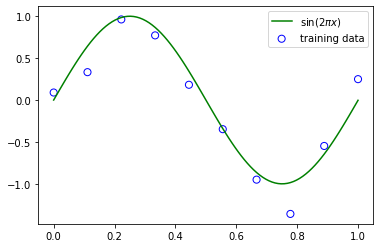

In [89]:
plt.scatter(x_train.get(), y_train.get(), facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test.get(), y_test.get(), c="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

In [90]:
fig1 = px.scatter(x= x_train.get(), y = y_train.get(), color=x_train.get())
fig2 = px.line (x = x_test.get(), y = y_test.get())
fig = go.Figure(data = fig1.data + fig2.data)
fig.show()

In [91]:
class PolynomialFeatures(object):

# polynomial features
# transforms input array with polynomial features
# Example
# =======
# 
#   x =  [[a, b],
#        [c, d]]
# 
#   y = PolynomialFeatures(degree=2).transform(x)
# 
#  y =   [[1, a, b, a^2, a * b, b^2],
#        [1, c, d, c^2, c * d, d^2]

  def __init__(self, degree=2):
    assert isinstance(degree, int)
    self.degree = degree

  def transform(self, x):
    if x.ndim == 1:
      x = x[:, None]
      x_t = x.transpose().get()  # https://github.com/cupy/cupy/issues/1084
      features = [np.ones(len(x))]    # https://github.com/cupy/cupy/issues/1084
      for degree in range(1, self.degree + 1):
          for items in itertools.combinations_with_replacement(x_t, degree):
              features.append(functools.reduce(lambda x, y: x * y, items))
      features = np.array(features)  # https://github.com/cupy/cupy/issues/1084
      return cp.asarray(features).transpose()


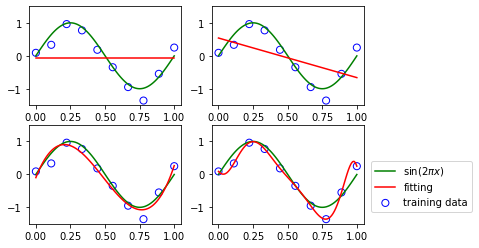

In [92]:
for i, degree in enumerate([0, 1, 3, 9]):
    plt.subplot(2, 2, i + 1)
    feature = PolynomialFeatures(degree)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)

    plt.scatter(x_train.get(), y_train.get(), facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test.get(), y_test.get(), c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test.get(), y.get(), c="r", label="fitting")
    plt.ylim(-1.5, 1.5)
    plt.annotate("M={}".format(degree), xy=(-0.15, 1))
  
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()

In [93]:
def rmse(a, b):
    return cp.sqrt(cp.mean(cp.square(a - b)))

training_errors = []
test_errors = []


In [94]:
for i in range(10):
    feature = PolynomialFeatures(i)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)

    # training_errors.append(rmse(model.predict(X_train), y_train))
    # test_errors.append(rmse(model.predict(X_test), y_test + cp.random.normal(scale=0.25, size=len(y_test))))
    ii = (rmse(model.predict(X_train), y_train)).get()
    training_errors.append(ii)

    jj = (rmse(model.predict(X_test), y_test + cp.random.normal(scale=0.25, size=len(y_test)))).get()
    test_errors.append(jj)

    np.array(training_errors)
    np.array(test_errors)

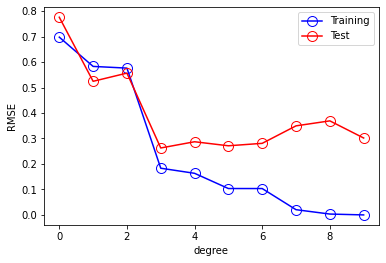

In [97]:
plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("RMSE")
plt.show()

# Regularisation

In [99]:
class RidgeRegression(Regressor):
    """
    Ridge regression model
    w* = argmin |t - X @ w| + a * |w|_2^2
    """

    def __init__(self, alpha=1.):
        self.alpha = alpha

    def _fit(self, X, t):
        eye = cp.eye(np.size(X, 1))
        self.w = cp.linalg.solve(self.alpha * eye + X.T @ X, X.T @ t)

    def _predict(self, X):
        y = X @ self.w
        return y

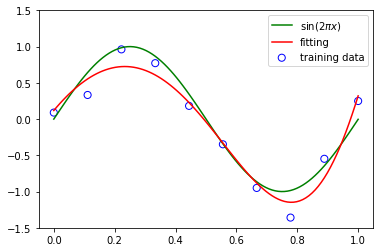

In [101]:
feature = PolynomialFeatures(9)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = RidgeRegression(alpha=1e-3)
model.fit(X_train, y_train)
y = model.predict(X_test)

y = model.predict(X_test)
plt.scatter(x_train.get(), y_train.get(), facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test.get(), y_test.get(), c="g", label="$\sin(2\pi x)$")
plt.plot(x_test.get(), y.get(), c="r", label="fitting")
plt.ylim(-1.5, 1.5)
plt.legend()
plt.annotate("M=9", xy=(-0.15, 1))
plt.show()

#Bayesian Curve Fitting

In [104]:
class BayesianRegressor(Regressor):
    """
    Bayesian regression model
    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha=1., beta=1.):
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None
        self.w_precision = None

    def _fit(self, X, t):
        if self.w_mean is not None:
            mean_prev = self.w_mean
        else:
            mean_prev = cp.zeros(np.size(X, 1))
        if self.w_precision is not None:
            precision_prev = self.w_precision
        else:
            precision_prev = self.alpha * cp.eye(cp.size(X, 1))
        w_precision = precision_prev + self.beta * X.T @ X
        w_mean = cp.linalg.solve(
            w_precision,
            precision_prev @ mean_prev + self.beta * X.T @ t
        )
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = cp.linalg.inv(self.w_precision)

    def _predict(self, X, return_std=False, sample_size=None):
        if isinstance(sample_size, int):
            w_sample = cp.random.multivariate_normal(
                self.w_mean, self.w_cov, size=sample_size
            )
            y = X @ w_sample.T
            return y
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + cp.sum(X @ self.w_cov * X, axis=1)
            y_std = cp.sqrt(y_var)
            return y, y_std
        return y

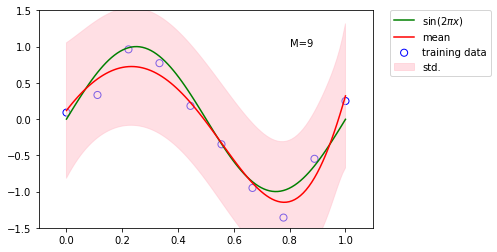

In [105]:
model = BayesianRegressor(alpha=2e-3, beta=2)
model.fit(X_train, y_train)

y, y_err = model.predict(X_test, return_std=True)
plt.scatter(x_train.get(), y_train.get(), facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test.get(), y_test.get(), c="g", label="$\sin(2\pi x)$")
plt.plot(x_test.get(), y.get(), c="r", label="mean")
plt.fill_between(x_test.get(), (y - y_err).get(), (y + y_err).get(), color="pink", label="std.", alpha=0.5)
plt.xlim(-0.1, 1.1)
plt.ylim(-1.5, 1.5)
plt.annotate("M=9", xy=(0.8, 1))
plt.legend(bbox_to_anchor=(1.05, 1.), loc=2, borderaxespad=0.)
plt.show()